<a href="https://colab.research.google.com/github/Manisha-Karim/Disease-Prediction-from-Sentiments/blob/main/Disease_Prediction_from_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import itertools
import string
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics


In [2]:
df=pd.read_csv('/content/drive/MyDrive/Datasets/Drug reviews/drugsComTrain_raw.csv')

In [3]:
test = pd.read_csv('/content/drive/MyDrive/Datasets/Drug reviews/drugsComTest_raw.csv')

In [4]:
df.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


# Exploratory Data Analysis

In [5]:
df.condition.nunique()

884

There are two many diseases. Let's just consider the 10 most frequent ones.

<Axes: >

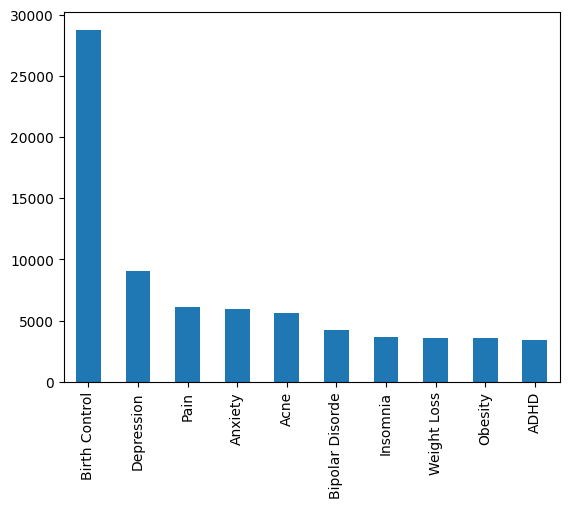

In [6]:
(df.condition.value_counts()).head(10).plot(kind = 'bar')

In [7]:
df = df[(df['condition'] == 'Birth Control')| (df['condition'] ==  'Depression')| (df['condition'] == 'Pain')| (df['condition'] == 'Anxiety')
         | (df['condition'] == 'Acne') | (df['condition'] =='Bipolar Disorde') | (df['condition'] == 'Insomnia') | (df['condition'] == 'Weight Loss')
         | (df['condition'] == 'Obesity') | (df['condition'] == 'ADHD')]



In [8]:
test = test[(test['condition'] == 'Birth Control')| (test['condition'] ==  'Depression')| (test['condition'] == 'Pain')| (test['condition'] == 'Anxiety')
         | (test['condition'] == 'Acne') | (test['condition'] =='Bipolar Disorde') | (test['condition'] == 'Insomnia') | (test['condition'] == 'Weight Loss')
         | (test['condition'] == 'Obesity') | (test['condition'] == 'ADHD')]

Text(0.5, 1.0, 'Word cloud for Birth control')

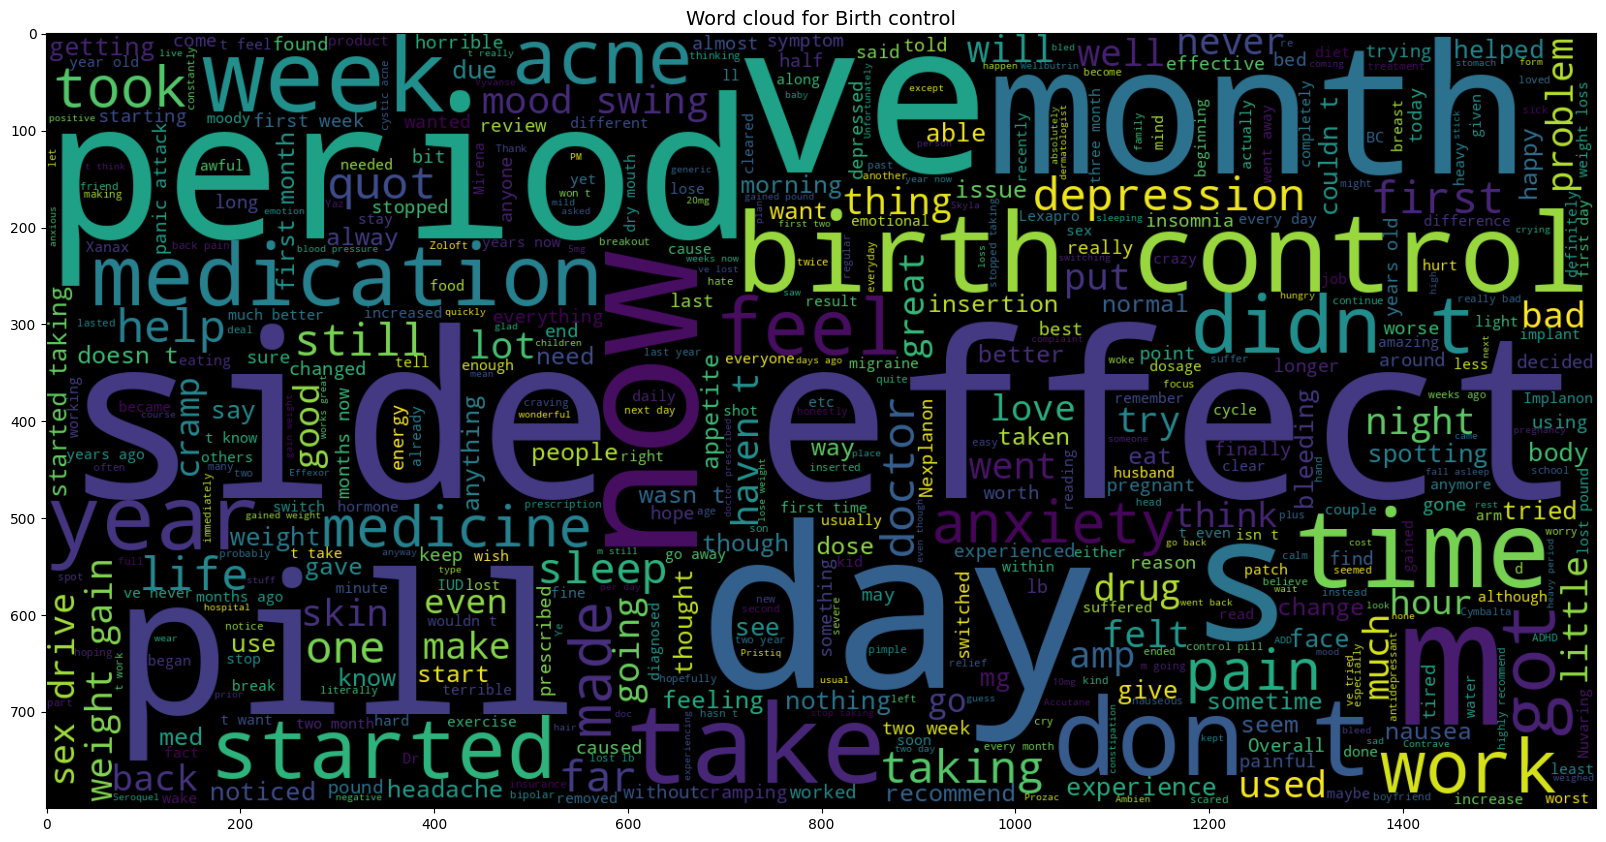

In [9]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 500 , width = 1600 , height = 800).generate(" ".join(df.review))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word cloud for Birth control',fontsize=14)

Text(0.5, 1.0, 'Word cloud for Birth control')

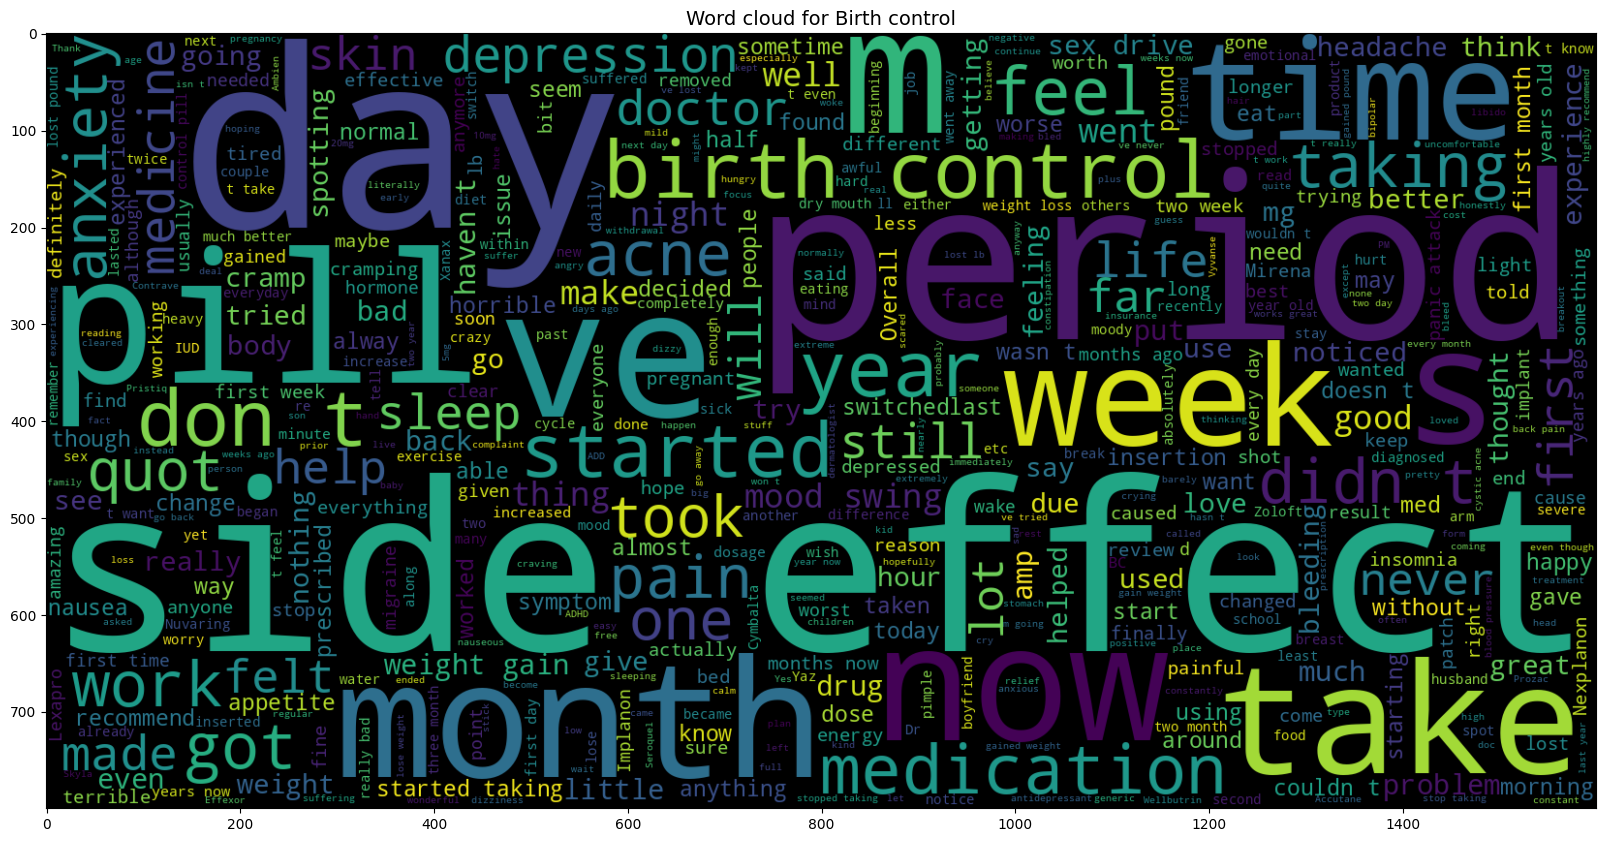

In [10]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 500 , width = 1600 , height = 800).generate(" ".join(test.review))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word cloud for Birth control',fontsize=14)

# Clean Data

In [11]:
nltk.download('stopwords')
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
porter = PorterStemmer()

In [13]:
from bs4 import BeautifulSoup
import re

1. Remove HTML characters
2. Remove Symbols
3. Remove Stopwords
4. Stemmatize

In [14]:
def clean_words(raw_text):
  remove_HTML = BeautifulSoup(raw_text, 'html.parser').get_text()
  remove_symbols = re.sub('[^a-zA-z]',' ', remove_HTML)
  lowercase = remove_symbols.lower().split()
  remove_stopwords = [words for words in lowercase if not words in stop]
  stemmed = [porter.stem(words) for words in remove_stopwords]
  return ( ' '.join(stemmed))

In [15]:
df['review'] = df['review'].fillna('')
df['clean'] = df['review'].apply(clean_words)

<ipython-input-14-6f4101b781f3>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  remove_HTML = BeautifulSoup(raw_text, 'html.parser').get_text()


In [16]:
test['review'] = test['review'].fillna('')
test['clean'] = test['review'].apply(clean_words)

<ipython-input-14-6f4101b781f3>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  remove_HTML = BeautifulSoup(raw_text, 'html.parser').get_text()


In [17]:
df.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,clean
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,son halfway fourth week intuniv becam concern ...
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,use take anoth oral contracept pill cycl happi...
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,first time use form birth control glad went pa...
7,102654,Aripiprazole,Bipolar Disorde,"""Abilify changed my life. There is hope. I was...",10,14-Mar-15,32,abilifi chang life hope zoloft clonidin first ...
9,48928,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8,8-Dec-16,1,pill mani year doctor chang rx chateal effect ...


In [18]:
test.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,clean
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22,tri antidepress year citalopram fluoxetin amit...
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35,contrav combin drug use alcohol smoke opioid c...
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4,birth control one cycl read review type simila...
6,215892,Copper,Birth Control,"""I&#039;ve had the copper coil for about 3 mon...",6,6-Jun-16,1,copper coil month realli excit thought take ho...
9,71428,Levora,Birth Control,"""I was on this pill for almost two years. It d...",2,16-Apr-11,3,pill almost two year work far get pregnant how...


In [19]:
df.dropna(inplace = True)
test.dropna(inplace = True)

In [20]:
X_train = df['clean']
y_train = df['condition']
X_test = test['clean']
y_test = test['condition']

In [21]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8)
tfidf_train_2 = tfidf_vectorizer.fit_transform(X_train)
tfidf_test_2 = tfidf_vectorizer.transform(X_test)

In [22]:
mnb_tf = MultinomialNB()
mnb_tf.fit(tfidf_train_2, y_train)
pred = mnb_tf.predict(tfidf_test_2)
score = metrics.accuracy_score(y_test, pred)

In [23]:
print("accuracy:   %0.2f" % score)

accuracy:   0.78


In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [25]:
df['condition'].unique()

array(['ADHD', 'Birth Control', 'Bipolar Disorde', 'Depression',
       'Obesity', 'Insomnia', 'Pain', 'Anxiety', 'Acne', 'Weight Loss'],
      dtype=object)

Confusion matrix, without normalization


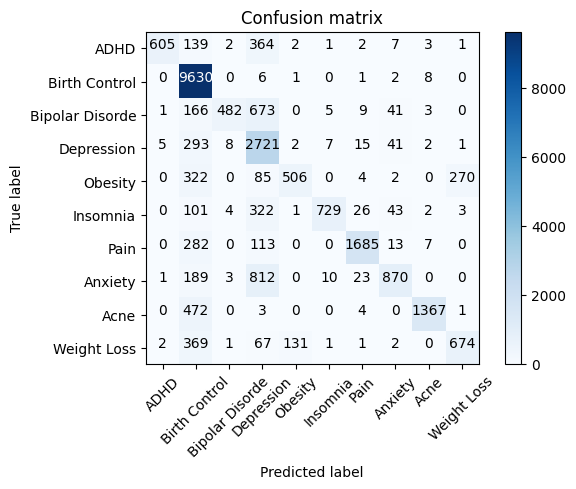

In [26]:
cm = metrics.confusion_matrix(y_test, pred, labels=['ADHD', 'Birth Control', 'Bipolar Disorde', 'Depression',
                                                    'Obesity', 'Insomnia', 'Pain', 'Anxiety', 'Acne', 'Weight Loss'])
plot_confusion_matrix(cm, classes=['ADHD', 'Birth Control', 'Bipolar Disorde', 'Depression',
                                   'Obesity', 'Insomnia', 'Pain', 'Anxiety', 'Acne', 'Weight Loss'])